In [119]:
from skimage import io
import PIL.Image
import numpy as np
import os

In [164]:
#Feature Matrix
array_of_samples = np.empty((1,57600))
directory = os.fsencode('RGB_PNG')
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith(".png"):   #this has to be here due to some file .ipynb_checkpoints
        img = io.imread('RGB_PNG/' + filename) #load an image
        four_dim_array = np.array(img)
        one_dim_array = four_dim_array.reshape(1,57600) #conversion into one long row
        array_of_samples = np.vstack([array_of_samples, one_dim_array])
print(array_of_samples.shape)
array_of_samples = array_of_samples[1:][:] #delete the first empty row
print(array_of_samples.shape)

(722, 57600)
,(721, 57600)


In [165]:
#Labels
"""
#ALL TYPES - comment out when we want to specify the types
import pandas as pd
my_csv = pd.read_csv('pokemon.csv')
my_csv = my_csv[:721]
my_csv = my_csv.sort_values(by = 'Name')      
labels = np.array(my_csv.Type1)
"""

#SPECIFIC TYPES - comment out when we don't want to specify the types
import pandas as pd
my_csv = pd.read_csv('pokemon.csv')
my_csv = my_csv[:721]                  #use or not, depending on the picture set 
my_csv = my_csv.sort_values(by = 'Name')
print(my_csv)


types = ['Fire', 'Water']            #NARROWING THE TYPES
array_of_samples = array_of_samples[np.array(my_csv['Type1'].isin(types)), :]
my_csv = my_csv[my_csv['Type1'].isin(types)]


print(my_csv)
print(array_of_samples)

labels = np.array(my_csv.Type1)
#print(labels)
print(array_of_samples.shape, labels.shape)
#the end of type filtering

print(my_csv.Type1.unique())


#Conversion of types(labels) to numbers
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
labels = le.fit_transform(labels)
labels = np.expand_dims(labels, axis = 1) #conversion into a vector that we need
labels.shape

                Name    Type1   Type2
,459        abomasnow    Grass     Ice
,62              abra  Psychic     NaN
,358            absol     Dark     NaN
,616         accelgor      Bug     NaN
,680  aegislash-blade    Steel   Ghost
,..               ...      ...     ...
,570          zoroark     Dark     NaN
,569            zorua     Dark     NaN
,40             zubat   Poison  Flying
,633         zweilous     Dark  Dragon
,717       zygarde-50   Dragon  Ground
,
,[721 rows x 3 columns]
,                     Name  Type1   Type2
,593             alomomola  Water     NaN
,58               arcanine   Fire     NaN
,183             azumarill  Water   Fairy
,338              barboach  Water  Ground
,549  basculin-red-striped  Water     NaN
,..                    ...    ...     ...
,320               wailord  Water     NaN
,7               wartortle  Water     NaN
,339              whiscash  Water  Ground
,277               wingull  Water  Flying
,193                wooper  Water  Ground
,
,

(152, 1)

In [166]:
#Division into Training and Test set

array_of_samples /= 255

from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(array_of_samples, labels, test_size=0.20, random_state=21, stratify = labels)
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

y_train = y_train.flatten()
y_valid = y_valid.flatten()                   #flatten so it corresponds to what was in the course

x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((121, 57600), (31, 57600), (121,), (31,))

In [167]:
#Categorize Labels
import tensorflow.keras as keras
num_classes = 2               #18 pokemon types

y_train = keras.utils.to_categorical(y_train, num_classes)
y_valid = keras.utils.to_categorical(y_valid, num_classes)

In [168]:
x_train = x_train.reshape(-1, 120, 120, 4)
x_valid = x_valid.reshape(-1, 120, 120, 4)

In [169]:
x_train.shape

(121, 120, 120, 4)

In [170]:
x_valid.shape

(31, 120, 120, 4)

In [171]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense,
    Conv2D,
    MaxPool2D,
    Flatten,
    Dropout,
    BatchNormalization,
)

model = Sequential()
model.add(Conv2D(75, (3, 3), strides=1, padding="same", activation="relu", 
                 input_shape=(120, 120, 4)))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(50, (3, 3), strides=1, padding="same", activation="relu"))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Conv2D(25, (3, 3), strides=1, padding="same", activation="relu"))
model.add(BatchNormalization())
model.add(MaxPool2D((2, 2), strides=2, padding="same"))
model.add(Flatten())
model.add(Dense(units=512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(units=num_classes, activation="softmax"))

In [172]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
    zoom_range=0.1,  # Randomly zoom image
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=True, # Don't randomly flip images vertically
)  

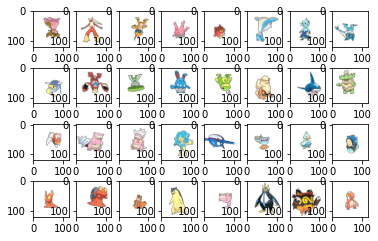

In [173]:
import matplotlib.pyplot as plt
import numpy as np
batch_size = 32
img_iter = datagen.flow(x_train, y_train, batch_size=batch_size)

x, y = img_iter.next()
fig, ax = plt.subplots(nrows=4, ncols=8)
for i in range(batch_size):
    image = x[i]
    ax.flatten()[i].imshow(np.squeeze(image))
plt.show()

In [174]:
datagen.fit(x_train)

In [175]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

In [176]:
history = model.fit(img_iter,
          epochs=30,
          steps_per_epoch=len(x_train)/batch_size, # Run same number of steps we would if we were not using a generator.
          validation_data=(x_valid, y_valid))

Epoch 1/30
,3/3 [==============================] - 8s 2s/step - loss: 11.3245 - accuracy: 0.5868 - val_loss: 0.6099 - val_accuracy: 0.7097
,Epoch 2/30
,3/3 [==============================] - 8s 2s/step - loss: 2.2360 - accuracy: 0.7603 - val_loss: 0.4311 - val_accuracy: 0.8065
,Epoch 3/30
,3/3 [==============================] - 10s 3s/step - loss: 0.6784 - accuracy: 0.8347 - val_loss: 0.4280 - val_accuracy: 0.8065
,Epoch 4/30
,3/3 [==============================] - 11s 3s/step - loss: 0.3823 - accuracy: 0.8760 - val_loss: 0.3972 - val_accuracy: 0.8387
,Epoch 5/30
,3/3 [==============================] - 10s 3s/step - loss: 0.6253 - accuracy: 0.8430 - val_loss: 0.3812 - val_accuracy: 0.8387
,Epoch 6/30
,3/3 [==============================] - 12s 3s/step - loss: 0.3431 - accuracy: 0.9008 - val_loss: 0.4537 - val_accuracy: 0.7097
,Epoch 7/30
,3/3 [==============================] - 11s 3s/step - loss: 0.2982 - accuracy: 0.8512 - val_loss: 0.3575 - val_accuracy: 0.8387
,Epoch 8/30
,3/3 [====